In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import wasserstein_distance  # Import Wasserstein distance

# Function to create the GAN
def build_gan(latent_dim):
    generator = models.Sequential([
        layers.Dense(128, input_shape=(latent_dim,), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(X_train.shape[1], activation='sigmoid')  # Output layer
    ])

    discriminator = models.Sequential([
        layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Output layer
    ])

    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = models.Model(gan_input, gan_output)

    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return generator, discriminator, gan

# Function to calculate Wasserstein distance
def calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2):
    # Compute the Wasserstein distance
    distance = wasserstein_distance(synthetic_data1.flatten(), synthetic_data2.flatten())
    return distance

# dataset loading
df = pd.read_csv('/Users/farhatlamiabarsha/Downloads/archive/Fraud_Data.csv')

# Preprocess data 
columns_to_drop = ['user_id', 'signup_time', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['year'] = df['purchase_time'].dt.year
df['month'] = df['purchase_time'].dt.month
df['day'] = df['purchase_time'].dt.day
df['hour'] = df['purchase_time'].dt.hour
df['minute'] = df['purchase_time'].dt.minute
df['second'] = df['purchase_time'].dt.second
df = df.drop('purchase_time', axis=1)
new_column_order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'purchase_value', 'class']
df = df[new_column_order]

# Downsampling the majority class (non-fraud) to match the number of fraud cases
non_fraud = df[df['class'] == 0].sample(df['class'].value_counts()[1])
fraud = df[df['class'] == 1]
df = pd.concat([fraud, non_fraud], ignore_index=True)

# Split the dataset into dependent and independent variables
X = df.drop(['class'], axis=1)
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Build and train the GAN
latent_dim = 100
generator, discriminator, gan = build_gan(latent_dim)

# Training the GAN
epochs = 10000
batch_size = 64

min_loss = float('inf')

# Lists to store generator and discriminator losses
generator_losses = []
discriminator_losses = []

for epoch in range(epochs):
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    generated_data = generator.predict(noise)
    
    idx_real = np.random.randint(0, X_train.shape[0], size=batch_size)
    real_data = X_train.iloc[idx_real]
    
    X_discriminator = np.concatenate([real_data, generated_data])
    y_discriminator = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    d_loss = discriminator.train_on_batch(X_discriminator, y_discriminator)
    
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    y_generator = np.ones((batch_size, 1))
    
    g_loss = gan.train_on_batch(noise, y_generator)
    
    # Append losses to the lists
    generator_losses.append(g_loss[0])
    discriminator_losses.append(d_loss[0])
    
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss[0]}")
    
    if epoch > 10 and epoch % 10 == 0:
        current_loss = g_loss[0]  # You may adjust this based on your preference
        if current_loss > min_loss:
            print(f"Early stopping at epoch {epoch} due to lack of improvement.")
            break
        else:
            min_loss = current_loss 

# After GAN training
latent_dim = 100
generator, _, _ = build_gan(latent_dim)

# Generate synthetic data using the trained generator
num_samples = X_test.shape[0]
noise1 = np.random.normal(0, 1, size=[num_samples, latent_dim])
noise2 = np.random.normal(0, 1, size=[num_samples, latent_dim])

synthetic_data1 = generator.predict(noise1)
synthetic_data2 = generator.predict(noise2)

# Calculate Wasserstein distance between synthetic_data1 and synthetic_data2
wasserstein_distance_value_synthetic = calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2)
print(f"Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: {wasserstein_distance_value_synthetic}")


# Continue with the rest of your code...
# ...
# Generate synthetic data using the trained generator
num_samples = X_test.shape[0]
synthetic_data = generator.predict(np.random.normal(0, 1, size=[num_samples, latent_dim]))

# Combine real and synthetic data
X_combined = pd.concat([X_train, pd.DataFrame(synthetic_data, columns=X_train.columns)], ignore_index=True)
y_combined = pd.concat([y_train, pd.Series(np.zeros(num_samples), name='class')], ignore_index=True)

# Train model
fraud_detection_model = LogisticRegression()
fraud_detection_model.fit(X_combined, y_combined)

# Evaluate the model on the test set
y_pred = fraud_detection_model.predict(X_test)

2/2 [==============================] - 0s 1ms/step


2024-01-24 23:52:15.738497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:15.838036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]


Epoch 0, Discriminator Loss: 3.2799832820892334, Generator Loss: 0.5632121562957764
2/2 [==============================] - 0s 864us/step
Epoch 10, Discriminator Loss: 3.488132953643799, Generator Loss: 0.5736217498779297


2024-01-24 23:52:16.075984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.078115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.096778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 1ms/step


2024-01-24 23:52:16.288941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.291531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.316162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 1ms/step
Epoch 20, Discriminator Loss: 2.303340196609497, Generator Loss: 0.5592336654663086
2/2 [==============================] - 0s 895us/step


2024-01-24 23:52:16.492299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.517052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.519664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]


2/2 [==============================] - 0s 739us/step
Epoch 30, Discriminator Loss: 6.76870059967041, Generator Loss: 0.546721875667572
2/2 [==============================] - 0s 757us/step


2024-01-24 23:52:16.692789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.695066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.713623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 912us/step
Epoch 40, Discriminator Loss: 4.825230121612549, Generator Loss: 0.5314188003540039
2/2 [==============================] - 0s 905us/step


2024-01-24 23:52:16.961738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.963820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:16.982659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 995us/step
Epoch 50, Discriminator Loss: 5.1985697746276855, Generator Loss: 0.5357969403266907
Early stopping at epoch 50 due to lack of improvement.
  1/177 [..............................] - ETA: 4s

2024-01-24 23:52:17.175415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:17.177501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:52:17.198894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

177/177 [==============================] - 0s 216us/step
Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: 0.0013657230823201012
177/177 [==============================] - 0s 215us/step


/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

Accuracy: 0.6843313902137431
Precision: 0.6929162171880618
Recall: 0.6737762237762238
F1 Score: 0.6832121964190747


/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

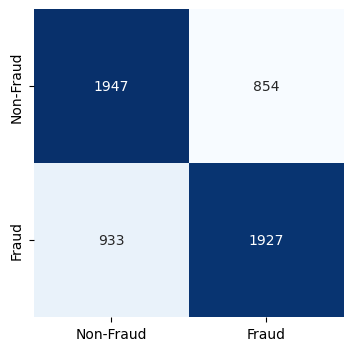

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])

Accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", Accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [9]:
import pandas as pd

df = pd.read_csv('/Users/farhatlamiabarsha/Downloads/archive/Fraud_Data.csv')

# Select 100 random rows from the original dataset
new_dataset = df.sample(n=500, random_state=42)  

# Specify the file path where you want to save the new dataset
output_file_path = '/Users/farhatlamiabarsha/Downloads/new_dataset1.csv'  

# Save the new dataset to a CSV file
new_dataset.to_csv(output_file_path, index=False)

print(f"New dataset saved to: {output_file_path}")

New dataset saved to: /Users/farhatlamiabarsha/Downloads/new_dataset1.csv


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import wasserstein_distance  # Import Wasserstein distance

# Function to create the GAN
def build_gan(latent_dim):
    generator = models.Sequential([
        layers.Dense(128, input_shape=(latent_dim,), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(X_train.shape[1], activation='sigmoid')  # Output layer
    ])

    discriminator = models.Sequential([
        layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Output layer
    ])

    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = models.Model(gan_input, gan_output)

    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return generator, discriminator, gan

# Function to calculate Wasserstein distance
def calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2):
    # Compute the Wasserstein distance
    distance = wasserstein_distance(synthetic_data1.flatten(), synthetic_data2.flatten())
    return distance

# dataset loading
df = pd.read_csv('/Users/farhatlamiabarsha/Downloads/new_dataset1.csv')

# Preprocess data 
columns_to_drop = ['user_id', 'signup_time', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['year'] = df['purchase_time'].dt.year
df['month'] = df['purchase_time'].dt.month
df['day'] = df['purchase_time'].dt.day
df['hour'] = df['purchase_time'].dt.hour
df['minute'] = df['purchase_time'].dt.minute
df['second'] = df['purchase_time'].dt.second
df = df.drop('purchase_time', axis=1)
new_column_order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'purchase_value', 'class']
df = df[new_column_order]

# Downsampling the majority class (non-fraud) to match the number of fraud cases
non_fraud = df[df['class'] == 0].sample(df['class'].value_counts()[1])
fraud = df[df['class'] == 1]
df = pd.concat([fraud, non_fraud], ignore_index=True)

# Split the dataset into dependent and independent variables
X = df.drop(['class'], axis=1)
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Build and train the GAN
latent_dim = 100
generator, discriminator, gan = build_gan(latent_dim)

# Training the GAN
epochs = 10000
batch_size = 64

min_loss = float('inf')

# Lists to store generator and discriminator losses
generator_losses = []
discriminator_losses = []

for epoch in range(epochs):
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    generated_data = generator.predict(noise)
    
    idx_real = np.random.randint(0, X_train.shape[0], size=batch_size)
    real_data = X_train.iloc[idx_real]
    
    X_discriminator = np.concatenate([real_data, generated_data])
    y_discriminator = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    d_loss = discriminator.train_on_batch(X_discriminator, y_discriminator)
    
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    y_generator = np.ones((batch_size, 1))
    
    g_loss = gan.train_on_batch(noise, y_generator)
    
    # Append losses to the lists
    generator_losses.append(g_loss[0])
    discriminator_losses.append(d_loss[0])
    
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss[0]}")
    
    if epoch > 10 and epoch % 10 == 0:
        current_loss = g_loss[0]  # You may adjust this based on your preference
        if current_loss > min_loss:
            print(f"Early stopping at epoch {epoch} due to lack of improvement.")
            break
        else:
            min_loss = current_loss 

# After GAN training
latent_dim = 100
generator, _, _ = build_gan(latent_dim)

# Generate synthetic data using the trained generator
num_samples = X_test.shape[0]
noise1 = np.random.normal(0, 1, size=[num_samples, latent_dim])
noise2 = np.random.normal(0, 1, size=[num_samples, latent_dim])

synthetic_data1 = generator.predict(noise1)
synthetic_data2 = generator.predict(noise2)

# Calculate Wasserstein distance between synthetic_data1 and synthetic_data2
wasserstein_distance_value_synthetic = calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2)
print(f"Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: {wasserstein_distance_value_synthetic}")


# Continue with the rest of your code...
# ...
# Generate synthetic data using the trained generator
num_samples = X_test.shape[0]
synthetic_data = generator.predict(np.random.normal(0, 1, size=[num_samples, latent_dim]))

# Combine real and synthetic data
X_combined = pd.concat([X_train, pd.DataFrame(synthetic_data, columns=X_train.columns)], ignore_index=True)
y_combined = pd.concat([y_train, pd.Series(np.zeros(num_samples), name='class')], ignore_index=True)

# Train model
fraud_detection_model = LogisticRegression()
fraud_detection_model.fit(X_combined, y_combined)

# Evaluate the model on the test set
y_pred = fraud_detection_model.predict(X_test)

2/2 [==============================] - 0s 951us/step


2024-01-24 23:56:13.939162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:56:14.027268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]


Epoch 0, Discriminator Loss: 9.289722442626953, Generator Loss: 0.6432108283042908
2/2 [==============================] - 0s 862us/step


2024-01-24 23:56:14.268204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:56:14.270748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:56:14.291677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

Epoch 10, Discriminator Loss: 14.44754409790039, Generator Loss: 0.6510568261146545
2/2 [==============================] - 0s 871us/step


2024-01-24 23:56:14.487899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:56:14.490686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:56:14.510823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 886us/step
Epoch 20, Discriminator Loss: 13.42923641204834, Generator Loss: 0.6384243965148926
2/2 [==============================] - 0s 835us/step


2024-01-24 23:56:14.692640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:56:14.695027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:56:14.714892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 824us/step
Epoch 30, Discriminator Loss: 13.018210411071777, Generator Loss: 0.6615642309188843
Early stopping at epoch 30 due to lack of improvement.
1/1 [==============================] - 0s 7ms/step
Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: 0.014033919880314476
1/1 [==============================] - 0s 7ms/step


2024-01-24 23:56:14.903635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 23:56:14.906150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/

Accuracy: 0.7222222222222222
Precision: 0.625
Recall: 0.7142857142857143
F1 Score: 0.6666666666666666


/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

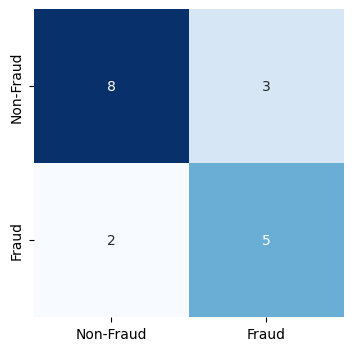

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])

Accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", Accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)